In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

In [2]:
df = pd.read_csv('traffic_moscow.csv', header=None)
df.columns = ["i", "j", "amt", "t", "s"]

In [3]:
def costs_func(i, j, column):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    c = columns[column]
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return 0

def create_T_d():
    T = np.zeros((22, 22))
    d = np.zeros((22, 22))
    
    for i in range(0, 22):
        for j in range(0, 22):
            
            T[i][j] = costs_func(i, j, 't')
            d[i][j] = costs_func(i, j, 'amt')
    
    return T, d

In [4]:
num_iter = 2500
alpha, beta = 1.0, 1.0
n = 22

L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

W = W_j.as_matrix()[:, 1]
L = L_i.as_matrix()[:, 1]

people_num = np.sum(W)

W = W / np.sum(W)
L = L / np.sum(L)

T, d = create_T_d()

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [57]:
def Sinkhorn(k, lambda_W_prev, lambda_L_prev):
    summa = 0
    
    lambda_L = np.zeros((n, ), dtype=float)
    lambda_W = np.zeros((n, ), dtype=float)
    
    if k % 2 == 0:
        for i in range(n):
            for j in range(n):
                summa += ( np.exp(-lambda_W_prev[j]) / 
                            L[i] * np.exp(1 + beta * alpha * T[i][j]) )
            lambda_L[i] = np.log(summa)
            summa = 0
        lambda_W = lambda_W_prev
    else:
        for j in range(n):
            for i in range(n):
                summa += ( np.exp(-lambda_L_prev[i]) / 
                            W[j] * np.exp(1 + beta * alpha * T[i][j]) )
            lambda_W[j] = np.log(summa)
            summa = 0
        lambda_L = lambda_L_prev
        
    return lambda_W, lambda_L

def iterate(beta, alpha, L, W, num_iter, eps):
    
    lambda_L = np.zeros((n, ), dtype=float)
    lambda_W = np.zeros((n, ), dtype=float)
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, lambda_W, lambda_L)
        
        delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L, 
                                               lambda_Wn - lambda_W)))
        
        if delta < eps:
            break
            
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
    
    r = error_d_i_j(lambda_Ln, lambda_Wn, beta, alpha)
    
    return r

def error_d_i_j(lambda_L, lambda_W, beta, alpha):
    er = np.exp( -1 - T - (np.reshape(lambda_L, (22, 1)) + lambda_W))

    return er * people_num 

In [84]:
num_iter = 1500
alpha = 1.0
beta_range = np.arange(0.0, 0.1, 10**(-4))
res_list = []

for beta in beta_range:
    rec = iterate(beta, alpha, L, W, num_iter, eps=0.01)
    res_list.append(np.linalg.norm(d - rec) / 22**2)

In [85]:
np.min(res_list), res_list.index(np.min(res_list)), beta_range[res_list.index(np.min(res_list))]

(0.5710339751946193, 138, 0.013800000000000002)

In [81]:
print(np.shape(beta_range), np.shape(res_list))

(1000,) (1000,)


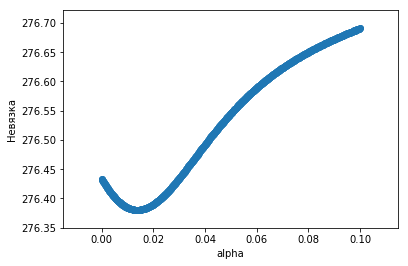

<Figure size 432x288 with 0 Axes>

In [82]:
plt.ticklabel_format(useOffset=False)

plt.scatter(beta_range, res_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()
plt.savefig('/Users/kate/Documents/MIPT/ТРАНСПОРТНЫЕ ПОТОКИ/Jupyter:Data/img/1.png')

In [ ]:
A = np.array([[1, 2], [2, 4]])
B = np.array([[5, 6], [7, 8]])

In [ ]:
A*B

In [ ]:
np.dot(A, B)

In [215]:
np.sum(np.dot(A, B))

123